# DOWNLOADING DATA

In [1]:
# !kaggle datasets download -d devicharith/language-translation-englishfrench

In [2]:
# !unzip language-translation-englishfrench.zip -d language-translation-englishfrench

# IMPORTS

In [19]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1733052101.890325     801 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733052101.915012     801 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733052101.915137     801 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# DATA EXPROLATION

In [5]:
english_french_data = pd.read_csv(
    "language-translation-englishfrench/eng_-french.csv", encoding="utf-8"
)
print(f"Number of sentences: {len(english_french_data)}")
english_sentence_words = english_french_data["English words/sentences"].apply(
    lambda x: len(str(x).split())
)
french_avg_sentence_words = english_french_data["French words/sentences"].apply(
    lambda x: len(str(x).split())
)
print(f"Min words in english sentences: {english_sentence_words.min()}")
print(f"Min words in french sentences: {french_avg_sentence_words.min()}")
print(f"Max words in english sentences: {english_sentence_words.max()}")
print(f"Max words in french sentences: {french_avg_sentence_words.max()}")
print(f"Average words in english sentences: {english_sentence_words.mean()}")
print(f"Average words in french sentences: {french_avg_sentence_words.mean()}")
english_french_data.head()

Number of sentences: 175621
Min words in english sentences: 1
Min words in french sentences: 1
Max words in english sentences: 44
Max words in french sentences: 55
Average words in english sentences: 6.161552433934438
Average words in french sentences: 6.706669475746067


,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [6]:
english_french_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175621 entries, 0 to 175620
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   English words/sentences  175621 non-null  object
 1   French words/sentences   175621 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [7]:
# shuffle the dataset as it was grouped from shortest to longest
english_french_data = english_french_data.sample(frac=1).reset_index(drop=True)

# Data pipeline

In [8]:
sentences_en = english_french_data["English words/sentences"].to_numpy()
sentences_fr = english_french_data["French words/sentences"].to_numpy()
val_len = int(0.1 * len(english_french_data))

sentences_en_train = sentences_en[:-val_len]
sentences_fr_train = sentences_fr[:-val_len]

sentences_en_val = sentences_en[-val_len:]
sentences_fr_val = sentences_fr[-val_len:]

In [9]:
def prepare_input_and_target(sentences_en, sentences_fr):
    return (sentences_en, b"<SOS> " + sentences_fr), sentences_fr + b" <EOS>"


def from_sentences_dataset(
    sentences_en,
    sentences_fr,
    batch_size,
):
    dataset = tf.data.Dataset.from_tensor_slices((sentences_en, sentences_fr))
    dataset = dataset.map(prepare_input_and_target, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size)

In [10]:
train_dataset = from_sentences_dataset(sentences_en_train, sentences_fr_train, batch_size=128)
val_dataset = from_sentences_dataset(sentences_en_val, sentences_fr_val,  batch_size=128)

I0000 00:00:1733052102.153758     801 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733052102.153918     801 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733052102.154040     801 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733052102.205094     801 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [11]:
def prepare_dataset(
    model,
    train_dataset,
    valid_dataset,
):
    model.vectorization_en.adapt(
        train_dataset.map(
            lambda sentences, target: sentences[0]
        )
    )
    model.vectorization_fr.adapt(
        train_dataset.map(
            lambda sentences, target: sentences[1] + b" <EOS>"
        )
    )

    train_dataset= train_dataset.map(
        lambda sentences, target: (sentences, model.vectorization_fr(target))
    ).prefetch(tf.data.AUTOTUNE)

    valid_dataset= valid_dataset.map(
        lambda sentences, target: (sentences, model.vectorization_fr(target))
    ).prefetch(tf.data.AUTOTUNE)

    return train_dataset, valid_dataset

gpu doesnt work for tf in this docker, if training is rlly slow, look into it

# Model

In [12]:
class PositionalEncoding(layers.Layer):
    def __init__(self, max_length, embedding_dim):
        super().__init__()
        if embedding_dim % 2 != 0:
            raise ValueError("Embedding dimension must be an even number")

        positions = np.arange(max_length)
        dimensions = np.arange(embedding_dim // 2)
        angles = positions[:, np.newaxis] / (10000 ** (2 * dimensions / embedding_dim))
        pos_encoding = np.zeros((max_length, embedding_dim))
        pos_encoding[:, 0::2] = np.sin(angles)
        pos_encoding[:, 1::2] = np.cos(angles)
        self.positional_encoding = tf.constant(pos_encoding[np.newaxis, :, :], dtype=tf.float32)
    
    def call(self, inputs):
        sequence_length = tf.shape(inputs)[1]
        return inputs + self.positional_encoding[:, :sequence_length, :]

In [13]:
class Encoder(layers.Layer):
    def __init__(
        self,
        embed_size,
        attention_heads,
        dense_dim,
        dropout_rate,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.multi_head_attention = layers.MultiHeadAttention(
            attention_heads, embed_size, dropout=dropout_rate
        )
        self.feed_forward = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_size),
                layers.Dropout(dropout_rate),
            ]
        )
        self.add = layers.Add()
        self.normalization = layers.LayerNormalization()

    def call(self, x, mask=None):
        skip_x= x
        x = self.multi_head_attention(x, value=x, attention_mask=mask)
        x = self.normalization(self.add([x, skip_x]))
        skip_x = x
        x = self.feed_forward(x)
        return self.normalization(self.add([x, skip_x]))


class Decoder(layers.Layer):
    def __init__(
        self,
        embed_size,
        attention_heads,
        dense_dim,
        dropout_rate,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.masked_multi_head_attention = layers.MultiHeadAttention(
            attention_heads, embed_size, dropout=dropout_rate
        )
        self.cross_attention = layers.MultiHeadAttention(
            attention_heads, embed_size, dropout=dropout_rate
        )
        self.feed_forward = keras.Sequential(
            [
                layers.Dense(
                    dense_dim, activation="relu"),
                layers.Dense(embed_size),
                layers.Dropout(dropout_rate),
            ]
        )
        self.add = layers.Add()
        self.normalization = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        decoder_mask, encoder_mask = mask
        x, encoder_output = inputs
        x_skip = x
        x = self.masked_multi_head_attention(x, value=x, attention_mask=decoder_mask)
        x = self.normalization(self.add([x, x_skip]))
        x_skip = x
        x = self.cross_attention(
            x, value=encoder_output, attention_mask=encoder_mask
        )
        x = self.normalization(self.add([x, x_skip]))
        x_skip = x
        x = self.feed_forward(x)
        return self.normalization(self.add([x, x_skip]))

In [14]:
class Transformer(keras.Model):
    def __init__(
        self,
        vocab_size=5000,
        max_seq_len=50,
        embed_size=256,
        encoder_decoder=1,
        attention_heads=8,
        dense_dim=256,
        dropout_rate=0.2,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_seq_len = max_seq_len

        self.vectorization_en = layers.TextVectorization(
            vocab_size, output_sequence_length=max_seq_len
        )
        self.vectorization_fr = layers.TextVectorization(
            vocab_size, output_sequence_length=max_seq_len
        )
        self.encoder_embedding = layers.Embedding(
            vocab_size, embed_size, mask_zero=True
        )
        self.decoder_embedding = layers.Embedding(
            vocab_size, embed_size, mask_zero=True
        )
        self.positional_encoding = PositionalEncoding(max_seq_len, embed_size)
        self.encoder_blocks = [
            Encoder(embed_size, attention_heads, dense_dim, dropout_rate)
            for _ in range(encoder_decoder)
        ]
        self.decoder_blocks = [
            Decoder(embed_size, attention_heads, dense_dim, dropout_rate)
            for _ in range(encoder_decoder)
        ]
        self.output_layer = layers.Dense(vocab_size, activation="softmax")

    def call(self, inputs):
        encoder_inputs, decoder_inputs = inputs

        encoder_input_ids = self.vectorization_en(encoder_inputs)
        decoder_input_ids = self.vectorization_fr(decoder_inputs)
        encoder_embeddings = self.encoder_embedding(encoder_input_ids)
        decoder_embeddings = self.decoder_embedding(decoder_input_ids)
        encoder_pos_embeddings = self.positional_encoding(encoder_embeddings)
        decoder_pos_embeddings = self.positional_encoding(decoder_embeddings)

        encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]
        decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]
        batch_max_len_decoder = tf.shape(decoder_embeddings)[1]
        decoder_causal_mask = tf.linalg.band_part(
            tf.ones((batch_max_len_decoder, batch_max_len_decoder), tf.bool), -1, 0
        )
        decoder_mask = decoder_causal_mask & decoder_pad_mask

        x = encoder_pos_embeddings
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x, mask=encoder_pad_mask)

        encoder_output = x
        x = decoder_pos_embeddings
        for decoder_block in self.decoder_blocks:
            x = decoder_block(
                [x, encoder_output], mask=[decoder_mask, encoder_pad_mask]
            )

        return self.output_layer(x)

In [15]:
model = Transformer()
train_dataset, val_dataset = prepare_dataset(model, train_dataset, val_dataset)

2024-12-01 11:21:44.712507: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-01 11:21:46.983465: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
scheduled_lr = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=100, decay_rate=0.9)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=scheduled_lr),
    metrics=["accuracy"],
)

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1235/1235 ━━━━━━━━━━━━━━━━━━━━ 54s 40ms/step - accuracy: 0.8598 - loss: 1.1049 - val_accuracy: 0.9005 - val_loss: 0.5630
Epoch 2/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.9016 - loss: 0.5456 - val_accuracy: 0.9065 - val_loss: 0.5002
Epoch 3/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.9067 - loss: 0.4953 - val_accuracy: 0.9081 - val_loss: 0.4857
Epoch 4/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.9084 - loss: 0.4818 - val_accuracy: 0.9088 - val_loss: 0.4813
Epoch 5/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.9089 - loss: 0.4777 - val_accuracy: 0.9089 - val_loss: 0.4801
Epoch 6/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.9090 - loss: 0.4766 - val_accuracy: 0.9090 - val_loss: 0.4797
Epoch 7/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.9090 - loss: 0.4762 - val_accuracy: 0.9090 - val_loss: 0.4796
Epoch 8/10
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.9090 - loss: 0.47

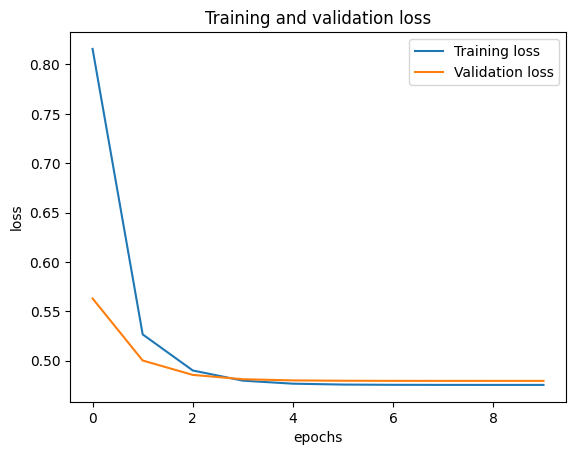

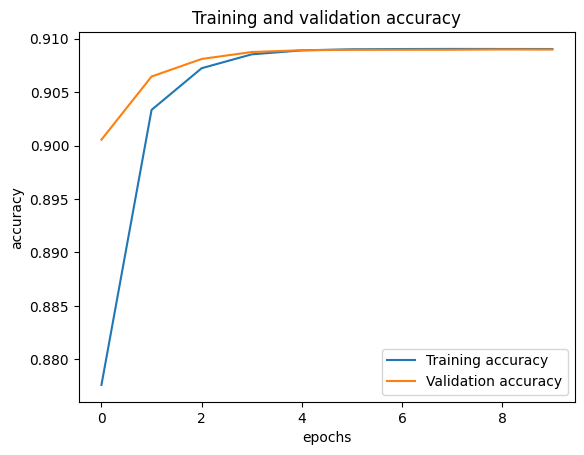

In [24]:
history_dict = history.history

plt.figure()
plt.plot(history_dict['loss'], label='Training loss')
plt.plot(history_dict['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.figure()
plt.plot(history_dict['accuracy'], label='Training accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()